### Imports

In [38]:
import pandas as pd
import numpy as np
import time
import requests
import matplotlib.pyplot as plt
import pickle
from geopy.geocoders import Nominatim, Photon
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

### Helper Functions

In [39]:
def mape(y_true, y_pred):
    """Mean absolute percentage error, safely."""
    y_true = np.nan_to_num(y_true, nan=0.0).flatten()
    y_pred = np.nan_to_num(y_pred, nan=0.0).flatten()
    mask = y_true > 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


def clean_municipality(label: str) -> str:
    """Clean municipality name based on group_label rules."""
    parts = [p.strip() for p in label.split("|")]
    county, municipality = parts[1], parts[2]
    if "_Others" in municipality:
        return county
    if municipality == county:
        return county
    return municipality


def geocode_place(place):
    """Geocode place name using Nominatim + Photon fallback."""
    geocoders = [
        Nominatim(user_agent="fortum_geo"),
        Photon(user_agent="fortum_geo")
    ]
    for g in geocoders:
        try:
            loc = g.geocode(place + ", Finland")
            if loc:
                return loc.latitude, loc.longitude
        except:
            pass
    print(f"⚠ Could not geocode: {place}")
    return None, None


def fetch_weather_yearly(lat, lon, municipality, max_retries=5):
    """Download hourly weather for 2021–2024 with rate-limit handling."""
    if pd.isna(lat) or pd.isna(lon):
        print(f"❌ No coordinates for {municipality}, skipping.")
        return None

    frames = []
    year_ranges = [
        ("2021-01-01", "2021-12-31"),
        ("2022-01-01", "2022-12-31"),
        ("2023-01-01", "2023-12-31"),
        ("2024-01-01", "2024-10-02")
    ]

    for start, end in year_ranges:
        url = (
            "https://archive-api.open-meteo.com/v1/archive"
            f"?latitude={lat}&longitude={lon}"
            f"&start_date={start}&end_date={end}"
            "&hourly=temperature_2m,relative_humidity_2m,"
            "dewpoint_2m,cloud_cover,wind_speed_10m,direct_radiation,"
            "shortwave_radiation&timezone=UTC"
        )

        for attempt in range(max_retries):
            try:
                r = requests.get(url)
                data = r.json()

                if "hourly" in data:
                    df = pd.DataFrame(data["hourly"])
                    df["measured_at"] = pd.to_datetime(df["time"], utc=True)
                    df = df.drop(columns=["time"])
                    frames.append(df)
                    print(f"✔ {municipality} {start} → {end}")
                    break

                if data.get("error") and "limit exceeded" in data.get("reason",""):
                    print(f"⏳ Rate limit → waiting 60s: {municipality}")
                    time.sleep(60)
                    continue

                print(f"⚠ Error {municipality} {start}: {data}")
                time.sleep(5)

            except Exception as e:
                print(f"❌ Exception: {municipality}: {e}")
                time.sleep(10)

    if not frames:
        return None

    return pd.concat(frames, ignore_index=True)


def compute_photoperiod(df):
    """Add solar day-length feature."""
    df["hour_of_year"] = (
        df["measured_at"].dt.dayofyear * 24 +
        df["measured_at"].dt.hour
    )
    df["day_length"] = (
        12 + 8 * np.sin(2 * np.pi * (df["hour_of_year"] / (365*24) - 0.2))
    )
    return df

### EDA

measured_at     object
28             float64
29             float64
30             float64
36             float64
                ...   
708            float64
709            float64
738            float64
740            float64
741            float64
Length: 113, dtype: object
Missing consumption: 0
Missing prices: 238
Negative prices:                            eur_per_mwh
measured_at                           
2021-04-04 23:00:00+00:00        -0.47
2021-04-05 00:00:00+00:00        -1.41
2021-04-05 01:00:00+00:00        -0.47
2021-04-05 02:00:00+00:00        -0.46
2021-04-05 03:00:00+00:00        -0.08
...                                ...
2024-09-26 01:00:00+00:00        -1.04
2024-09-26 02:00:00+00:00        -0.59
2024-09-29 10:00:00+00:00        -0.01
2024-09-29 11:00:00+00:00        -0.49
2024-09-29 12:00:00+00:00        -0.44

[1049 rows x 1 columns]
Negative consumption: 0
Missing cons: 0
Missing prices: 0


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


NameError: name 'plt' is not defined

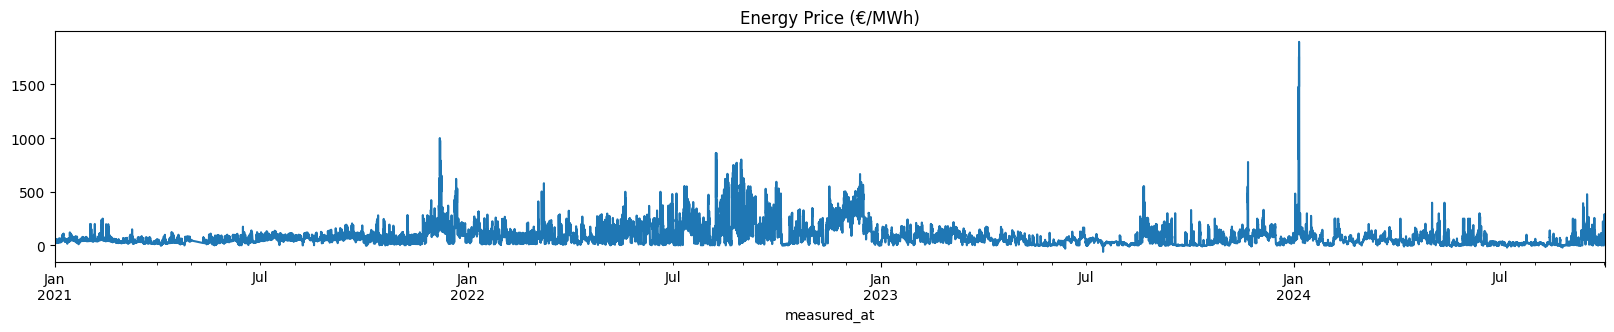

In [11]:
# =============================
# LOAD TRAINING DATA
# =============================
train = pd.read_excel(
    "/kaggle/input/fortumtraintest/20251111_JUNCTION_training.xlsx",
    sheet_name=None
)

cons   = train["training_consumption"]
print(cons.dtypes)
prices = train["training_prices"]
groups = train["groups"]

# Parse
cons["measured_at"]   = pd.to_datetime(cons["measured_at"])
prices["measured_at"] = pd.to_datetime(prices["measured_at"])

cons   = cons.set_index("measured_at").sort_index()
prices = prices.set_index("measured_at").sort_index()

cons_na = cons.isna().sum().sum()
prices_na = prices.isna().sum().sum()
print("Missing consumption:", cons_na)
print("Missing prices:", prices_na)

neg_prices = (prices["eur_per_mwh"] < 0)
neg_cons   = (cons < 0).sum().sum()

print("Negative prices:", prices[neg_prices])
print("Negative consumption:", neg_cons)

# Price fix
prices["eur_per_mwh"] = (
    prices["eur_per_mwh"]
    .interpolate()
    .ffill()
    .bfill()
)

# Check missing values
print("Missing cons:", cons.isna().sum().sum())
print("Missing prices:", prices.isna().sum().sum())

# Plot price
prices["eur_per_mwh"].plot(figsize=(20,3), title="Energy Price (€/MWh)")
plt.show()


In [41]:
cons.describe().T.sort_values("min").head(10)


,count,mean,std,min,25%,50%,75%,max
237,32856.0,0.151690,0.054728,0.052170,0.110862,0.142684,0.182436,0.399106
740,32856.0,0.152440,0.063058,0.052848,0.108873,0.138329,0.178174,0.447459
697,32856.0,0.161794,0.053664,0.059021,0.122161,0.153192,0.191819,0.403346
585,32856.0,0.164737,0.061413,0.061365,0.120501,0.152747,0.194816,0.414215
307,32856.0,0.167204,0.051428,0.076368,0.128886,0.161839,0.198751,0.418946
658,32856.0,0.185918,0.057370,0.082006,0.142985,0.178551,0.216730,0.450660
151,32856.0,0.204145,0.068346,0.083377,0.154832,0.192767,0.240435,0.571408
459,32856.0,0.231472,0.081593,0.083812,0.164227,0.220972,0.286761,0.528919
541,32856.0,0.204208,0.064155,0.084006,0.159535,0.197857,0.240223,0.519502
29,32856.0,0.191980,0.057188,0.084622,0.148541,0.185944,0.226106,0.507818


In [42]:
cons.describe().T.sort_values("max").tail(10)

,count,mean,std,min,25%,50%,75%,max
395,32856.0,3.091537,1.565955,0.806714,1.668520,2.862714,4.235095,8.842240
198,32856.0,2.730875,1.402817,0.699228,1.499790,2.540415,3.621063,8.874123
400,32856.0,3.088858,1.550446,0.806490,1.720802,2.847970,4.152897,9.010085
28,32856.0,5.223798,2.667409,1.303699,2.907439,4.713134,6.926131,15.694245
74,32856.0,5.123322,2.603249,1.397104,2.905065,4.696575,6.740926,15.722859
150,32856.0,5.517982,2.884058,1.350178,2.910239,5.113176,7.537543,16.203789
657,32856.0,5.355350,2.674043,1.575926,2.992986,4.914076,7.124883,16.462136
693,32856.0,5.451778,2.751786,1.663280,3.049744,4.942156,7.299291,16.766570
303,32856.0,5.522485,2.902650,1.468031,2.977949,4.956707,7.470955,17.077392
378,32856.0,5.817792,2.977359,1.661934,3.218282,5.285235,7.777612,18.135084


<Axes: xlabel='measured_at'>

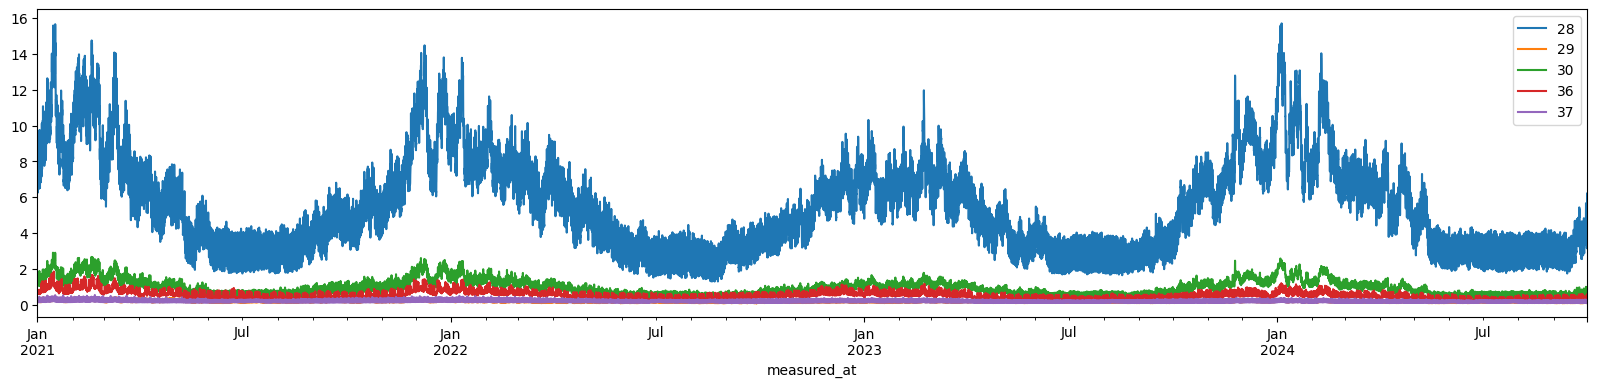

In [43]:
sample_groups = cons.columns[:5]  # first 5 groups
cons[sample_groups].plot(figsize=(20,4))


### Long Format Conversion + Time Features

In [44]:
# =============================
# LONG FORMAT
# =============================
cons_long = cons.reset_index().melt(
    id_vars="measured_at",
    var_name="group_id",
    value_name="consumption"
)
cons_long["group_id"] = cons_long["group_id"].astype(int)

price_long = prices.reset_index()[["measured_at", "eur_per_mwh"]]

df = cons_long.merge(price_long, on="measured_at", how="left")

# =============================
# TIME FEATURES
# =============================
df["hour"] = df["measured_at"].dt.hour
df["day_of_week"] = df["measured_at"].dt.dayofweek
df["month"] = df["measured_at"].dt.month
df["weekofyear"] = df["measured_at"].dt.isocalendar().week.astype(int)

# Cyclic encodings
df["hour_sin"]  = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"]  = np.cos(2*np.pi*df["hour"]/24)
df["dow_sin"]   = np.sin(2*np.pi*df["day_of_week"]/7)
df["dow_cos"]   = np.cos(2*np.pi*df["day_of_week"]/7)
df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
df["month_cos"] = np.cos(2*np.pi*df["month"]/12)

df


,measured_at,group_id,consumption,eur_per_mwh,hour,day_of_week,month,weekofyear,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos
0,2021-01-01 00:00:00+00:00,28,7.010736,24.35,0,4,1,53,0.000000,1.000000,-0.433884,-0.900969,0.5,8.660254e-01
1,2021-01-01 01:00:00+00:00,28,6.600845,23.98,1,4,1,53,0.258819,0.965926,-0.433884,-0.900969,0.5,8.660254e-01
2,2021-01-01 02:00:00+00:00,28,6.468329,23.72,2,4,1,53,0.500000,0.866025,-0.433884,-0.900969,0.5,8.660254e-01
3,2021-01-01 03:00:00+00:00,28,6.712097,23.73,3,4,1,53,0.707107,0.707107,-0.433884,-0.900969,0.5,8.660254e-01
4,2021-01-01 04:00:00+00:00,28,6.418159,24.06,4,4,1,53,0.866025,0.500000,-0.433884,-0.900969,0.5,8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3679867,2024-09-30 19:00:00+00:00,741,0.650630,4.19,19,0,9,40,-0.965926,0.258819,0.000000,1.000000,-1.0,-1.836970e-16
3679868,2024-09-30 20:00:00+00:00,741,0.604637,2.03,20,0,9,40,-0.866025,0.500000,0.000000,1.000000,-1.0,-1.836970e-16
3679869,2024-09-30 21:00:00+00:00,741,0.596577,0.00,21,0,9,40,-0.707107,0.707107,0.000000,1.000000,-1.0,-1.836970e-16
3679870,2024-09-30 22:00:00+00:00,741,0.494411,0.01,22,0,9,40,-0.500000,0.866025,0.000000,1.000000,-1.0,-1.836970e-16


### Hourly Lag Features

In [45]:
df = df.sort_values(["group_id", "measured_at"])

df["lag1"]   = df.groupby("group_id")["consumption"].shift(1)
df["lag24"]  = df.groupby("group_id")["consumption"].shift(24)
df["lag168"] = df.groupby("group_id")["consumption"].shift(168)

df["roll_mean_3"] = df.groupby("group_id")["consumption"].rolling(3).mean().reset_index(level=0, drop=True)
df["roll_mean_24"] = df.groupby("group_id")["consumption"].rolling(24).mean().reset_index(level=0, drop=True)
df["roll_mean_168"] = df.groupby("group_id")["consumption"].rolling(168).mean().reset_index(level=0, drop=True)

df = df.dropna().reset_index(drop=True)
df


,measured_at,group_id,consumption,eur_per_mwh,hour,day_of_week,month,weekofyear,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos,lag1,lag24,lag168,roll_mean_3,roll_mean_24,roll_mean_168
0,2021-01-08 00:00:00+00:00,28,8.410586,47.38,0,4,1,1,0.000000,1.000000,-0.433884,-0.900969,0.5,8.660254e-01,8.780465,7.948369,7.010736,8.971787,8.851972,8.276647
1,2021-01-08 01:00:00+00:00,28,8.330371,45.78,1,4,1,1,0.258819,0.965926,-0.433884,-0.900969,0.5,8.660254e-01,8.410586,7.753094,6.600845,8.507141,8.876025,8.286942
2,2021-01-08 02:00:00+00:00,28,8.198362,44.51,2,4,1,1,0.500000,0.866025,-0.433884,-0.900969,0.5,8.660254e-01,8.330371,7.812114,6.468329,8.313106,8.892119,8.297240
3,2021-01-08 03:00:00+00:00,28,8.341029,45.69,3,4,1,1,0.707107,0.707107,-0.433884,-0.900969,0.5,8.660254e-01,8.198362,8.153941,6.712097,8.289921,8.899914,8.306936
4,2021-01-08 04:00:00+00:00,28,8.891305,50.33,4,4,1,1,0.866025,0.500000,-0.433884,-0.900969,0.5,8.660254e-01,8.341029,8.670329,6.418159,8.476899,8.909121,8.321657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3661051,2024-09-30 19:00:00+00:00,741,0.650630,4.19,19,0,9,40,-0.965926,0.258819,0.000000,1.000000,-1.0,-1.836970e-16,0.639471,0.695166,0.590031,0.666956,0.606469,0.551214
3661052,2024-09-30 20:00:00+00:00,741,0.604637,2.03,20,0,9,40,-0.866025,0.500000,0.000000,1.000000,-1.0,-1.836970e-16,0.650630,0.625063,0.515644,0.631579,0.605618,0.551743
3661053,2024-09-30 21:00:00+00:00,741,0.596577,0.00,21,0,9,40,-0.707107,0.707107,0.000000,1.000000,-1.0,-1.836970e-16,0.604637,0.575196,0.501564,0.617281,0.606509,0.552309
3661054,2024-09-30 22:00:00+00:00,741,0.494411,0.01,22,0,9,40,-0.500000,0.866025,0.000000,1.000000,-1.0,-1.836970e-16,0.596577,0.521450,0.405694,0.565208,0.605382,0.552837


### Enrichment with Meteorology: Geocode + Weather Data

In [46]:
# =============================
# MUNICIPALITY CLEANING
# =============================
groups["municipality_clean"] = groups["group_label"].apply(clean_municipality)

group_meta = groups[["group_id","municipality_clean"]]
df = df.merge(group_meta, on="group_id", how="left")

# =============================
# GEOCODE ALL MUNICIPALITIES
# =============================
municipalities = groups["municipality_clean"].unique()
coords = {}

for m in municipalities:
    lat, lon = geocode_place(m)
    coords[m] = {"lat": lat, "lon": lon}
    print(m, lat, lon)
    time.sleep(1)

coords_df = pd.DataFrame.from_dict(coords, orient="index").reset_index()
coords_df.columns = ["municipality_clean","lat","lon"]

weather_frames = []

for _, row in coords_df.iterrows():
    muni = row["municipality_clean"]
    lat  = row["lat"]
    lon  = row["lon"]

    print(f"\n🌦 Fetching: {muni} ({lat}, {lon})")
    wdf = fetch_weather_yearly(lat, lon, muni)

    if wdf is not None:
        wdf["municipality_clean"] = muni
        weather_frames.append(wdf)

    time.sleep(5)

weather_final = pd.concat(weather_frames, ignore_index=True)
weather_final["measured_at"] = pd.to_datetime(weather_final["measured_at"], utc=True)

weather_final = weather_final.drop_duplicates(
    subset=["municipality_clean","measured_at"]
).reset_index(drop=True)

weather_final = compute_photoperiod(weather_final)

df_merged = df.merge(
    weather_final,
    on=["municipality_clean","measured_at"],
    how="left"
)

df_merged.shape


Etelä-Savo 61.8424126 28.0286389
Joensuu 62.6005753 29.7622128
Pohjois-Karjala 62.801052 30.2127116
Pohjois-Savo 63.0159354 27.6267896
Lappi 67.6922371 26.728139
Rovaniemi 66.5025657 25.73122
Oulu 65.0117869 25.4701983
Pohjois-Pohjanmaa 64.9521512 25.6968812
Lappeenranta 61.0583417 28.1862293
Kanta-Häme 60.9376961 24.1531919
Lahti 60.9826257 25.66137
Päijät-Häme 61.2296902 25.8105246
Espoo 60.2049651 24.6559808
Uusimaa 60.2246684 25.1272631
Vantaa 60.292997 25.0435254
Pori 61.4866126 21.7972071
Varsinais-Suomi 60.3036114 22.4113084
Etelä-Pohjanmaa 62.7389391 23.1124435
Jyväskylä 62.241672 25.7495806
Keski-Suomi 62.6093658 25.579461
Pirkanmaa 61.7174331 23.7157115
Tampere 61.4977929 23.7616372
Pohjanmaa 62.9651857 21.2099367

🌦 Fetching: Etelä-Savo (61.8424126, 28.0286389)
✔ Etelä-Savo 2021-01-01 → 2021-12-31
✔ Etelä-Savo 2022-01-01 → 2022-12-31
✔ Etelä-Savo 2023-01-01 → 2023-12-31
✔ Etelä-Savo 2024-01-01 → 2024-10-02

🌦 Fetching: Joensuu (62.6005753, 29.7622128)
✔ Joensuu 2021-01-01 → 

(3661056, 30)

### Preparation and Training of XGBoost Hourly Without Weather Encrichment (Reasoning in Docs)

In [47]:
# =============================
# FEATURES (HOURLY WITHOUT WEATHER)
# =============================
hourly_features = [
    "eur_per_mwh",
    "group_id",
    "hour","day_of_week","month","weekofyear",
    "hour_sin","hour_cos","dow_sin","dow_cos","month_sin","month_cos",
    "lag1","lag24","lag168",
    "roll_mean_3","roll_mean_24","roll_mean_168"
]

last_timestamp = df_merged["measured_at"].max()
eval_start = last_timestamp - pd.Timedelta(hours=47)
eval_end   = last_timestamp

train_df = df_merged[df_merged["measured_at"] < eval_start]
val_df   = df_merged[
    (df_merged["measured_at"] >= eval_start) &
    (df_merged["measured_at"] <= eval_end)
]

X_train = train_df[hourly_features]
y_train = train_df["consumption"]

X_val = val_df[hourly_features]
y_val = val_df["consumption"]


xgb_hourly = XGBRegressor(
    n_estimators=10000,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",
    objective="reg:squarederror",
    random_state=42
)

evals_result = {}

xgb_hourly.fit(
    X_train, y_train,
    eval_set=[(X_train,y_train), (X_val,y_val)],
    eval_metric="mae",
    verbose=300,
    early_stopping_rounds=300
)

pred_hourly = xgb_hourly.predict(X_val)

print("Hourly XGB MAE:", mean_absolute_error(y_val, pred_hourly))
print("Hourly XGB MAPE:", mape(y_val.values, pred_hourly))
# -----------------------------------------
# FIX HOURLY SUBMISSION FORMAT
# -----------------------------------------

# df_pred_hourly must contain:
#   - measured_at
#   - group_id
#   - prediction
# If not, we construct it using val_df and pred_hourly:

df_pred_hourly = val_df[["measured_at", "group_id"]].copy()
df_pred_hourly["prediction"] = pred_hourly

# pivot into wide format
hourly_wide = df_pred_hourly.pivot_table(
    index="measured_at",
    columns="group_id",
    values="prediction"
)

# sort columns numerically
hourly_wide = hourly_wide.sort_index(axis=1)

# convert index to submission timestamp format
hourly_wide.index = hourly_wide.index.strftime("%Y-%m-%dT%H:%M:%SZ")

# reset index and rename
hourly_wide = hourly_wide.reset_index().rename(columns={"measured_at": "timestamp"})

# ---------------------------------------------------
# SAVE in correct semicolon ( ; ) format
# ---------------------------------------------------
hourly_wide.to_csv(
    "/kaggle/working/hourly_forecast.csv",
    sep=";",
    index=False
)

hourly_wide.head()
pickle.dump(xgb_hourly, open("/kaggle/working/xgb_hourly.pkl","wb"))



/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:0.88330	validation_1-mae:0.80744
[300]	validation_0-mae:0.02713	validation_1-mae:0.02840
[600]	validation_0-mae:0.02485	validation_1-mae:0.02627
[900]	validation_0-mae:0.02350	validation_1-mae:0.02506
[1200]	validation_0-mae:0.02246	validation_1-mae:0.02416
[1500]	validation_0-mae:0.02169	validation_1-mae:0.02363
[1800]	validation_0-mae:0.02109	validation_1-mae:0.02319
[2100]	validation_0-mae:0.02055	validation_1-mae:0.02292
[2400]	validation_0-mae:0.02010	validation_1-mae:0.02264
[2700]	validation_0-mae:0.01972	validation_1-mae:0.02250
[3000]	validation_0-mae:0.01937	validation_1-mae:0.02240
[3300]	validation_0-mae:0.01905	validation_1-mae:0.02226
[3600]	validation_0-mae:0.01876	validation_1-mae:0.02212
[3900]	validation_0-mae:0.01848	validation_1-mae:0.02187
[4200]	validation_0-mae:0.01822	validation_1-mae:0.02163
[4500]	validation_0-mae:0.01797	validation_1-mae:0.02152
[4800]	validation_0-mae:0.01774	validation_1-mae:0.02142
[5100]	validation_0-mae:0.01752	valid

### Monthly Aggregation +Weather Enrichment (Proven to work better on monthly data) 

In [48]:
df_m = df_merged.copy()
df_m["month_start"] = df_m["measured_at"].dt.to_period("M").dt.to_timestamp()

monthly_totals = (
    df_m.groupby(["month_start","group_id"])["consumption"]
        .sum().reset_index()
)

weather_final["month_start"] = (
    weather_final["measured_at"].dt.to_period("M").dt.to_timestamp()
)

weather_monthly = (
    weather_final.groupby(["municipality_clean","month_start"])
    .agg({
        "temperature_2m":"mean",
        "relative_humidity_2m":"mean",
        "dewpoint_2m":"mean",
        "cloud_cover":"mean",
        "wind_speed_10m":"mean",
        "direct_radiation":"sum",
        "shortwave_radiation":"sum",
        "day_length":"mean"
    }).reset_index()
)

monthly_df = monthly_totals.merge(
    group_meta,
    on="group_id",
    how="left"
).merge(
    weather_monthly,
    on=["municipality_clean","month_start"],
    how="left"
)


/tmp/ipykernel_48/3178563291.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_m["month_start"] = df_m["measured_at"].dt.to_period("M").dt.to_timestamp()
/tmp/ipykernel_48/3178563291.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  weather_final["measured_at"].dt.to_period("M").dt.to_timestamp()


### Monthly Lag + Time Features

In [49]:
monthly_df["month"] = monthly_df["month_start"].dt.month
monthly_df["month_sin"] = np.sin(2*np.pi*monthly_df["month"]/12)
monthly_df["month_cos"] = np.cos(2*np.pi*monthly_df["month"]/12)

monthly_df = monthly_df.sort_values(["group_id","month_start"])

monthly_df["lag1"]  = monthly_df.groupby("group_id")["consumption"].shift(1)
monthly_df["lag12"] = monthly_df.groupby("group_id")["consumption"].shift(12)

monthly_df["roll3"] = (
    monthly_df.groupby("group_id")["consumption"]
    .rolling(3).mean().reset_index(level=0,drop=True)
)
monthly_df["roll12"] = (
    monthly_df.groupby("group_id")["consumption"]
    .rolling(12).mean().reset_index(level=0,drop=True)
)

monthly_df = monthly_df.dropna().reset_index(drop=True)


### Preparation of Data Training of XGB (Monthly WITH Weather)

In [50]:
weather_features_monthly = [
    "temperature_2m",
    "relative_humidity_2m",
    "dewpoint_2m",
    "cloud_cover",
    "wind_speed_10m",
    "direct_radiation",
    "shortwave_radiation",
    "day_length"
]

base_features = [
    "group_id",
    "month_sin", "month_cos",
    "lag1", "lag12",
    "roll3", "roll12"
]

features_with_weather = base_features + weather_features_monthly
features_no_weather = base_features
val_month = pd.Timestamp("2024-09-01")

train_months = monthly_df[monthly_df["month_start"] < val_month]
val_months   = monthly_df[monthly_df["month_start"] == val_month]

X_train_m = train_months[features_with_weather]
y_train_m = train_months["consumption"]

X_val_m = val_months[features_with_weather]
y_val_m = val_months["consumption"]




In [51]:
xgb_monthly = XGBRegressor(
    n_estimators=50000,
    learning_rate=0.01,
    max_depth=2,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=0.2,
    min_child_weight=5,
    tree_method="hist",
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb_monthly.fit(
    X_train_m, y_train_m,
    eval_set=[(X_train_m,y_train_m),(X_val_m,y_val_m)],
    eval_metric="mae",
    verbose=500,
    early_stopping_rounds=1500
)

pred_monthly = xgb_monthly.predict(X_val_m)

print("Monthly XGB MAE:", mean_absolute_error(y_val_m, pred_monthly))
print("Monthly XGB MAPE:", mape(y_val_m.values, pred_monthly))

pickle.dump(xgb_monthly, open("/kaggle/working/xgb_monthly.pkl","wb"))

# ======================================================
#  FUTURE 12-MONTH FORECAST (2024-10 → 2025-09)
# ======================================================

# ============================================
# 1) Generate 12 future month starts
# ============================================
future_months = pd.to_datetime([
    "2024-10-01","2024-11-01","2024-12-01",
    "2025-01-01","2025-02-01","2025-03-01",
    "2025-04-01","2025-05-01","2025-06-01",
    "2025-07-01","2025-08-01","2025-09-01"
])
last_rows = monthly_df.sort_values("month_start").groupby("group_id").tail(1)
future_rows = []

for ts in future_months:
    for _, row in last_rows.iterrows():

        new_row = row.copy()

        new_row["month_start"] = ts
        m = ts.month

        # cyclical encodings
        new_row["month"] = m
        new_row["month_sin"] = np.sin(2*np.pi*m/12)
        new_row["month_cos"] = np.cos(2*np.pi*m/12)

        # lag1 = last value observed  
        new_row["lag1"] = row["consumption"]

        # lag12 = previous month’s lag11 OR use last lag12
        new_row["lag12"] = row.get("lag11", row["lag12"])

        # rolling features unchanged
        new_row["roll3"]  = row["roll3"]
        new_row["roll12"] = row["roll12"]

        # weather = reused last known month
        for w in weather_features_monthly:
            new_row[w] = row[w]

        future_rows.append(new_row)

future_df = pd.DataFrame(future_rows)
X_future_m = future_df[features_with_weather]
pred_future_months = xgb_monthly.predict(X_future_m)
# Reshape predictions into (12 rows, 112 columns)
pred_matrix = pred_future_months.reshape(len(future_months), -1)

group_ids = sorted(monthly_df["group_id"].unique())  # 112 group IDs

monthly_submission = pd.DataFrame(
    pred_matrix,
    columns=group_ids
)

monthly_submission.insert(
    0,
    "measured_at",
    [ts.strftime("%Y-%m-%dT00:00:00.000Z") for ts in future_months]
)
monthly_submission_formatted = monthly_submission.copy()

# Convert all numeric columns from "." to ","
for g in group_ids:
    monthly_submission_formatted[g] = (
        monthly_submission_formatted[g]
        .astype(str)
        .str.replace(".", ",")
    )

monthly_submission_formatted.to_csv(
    "/kaggle/working/monthly_forecast.csv",
    sep=";",
    index=False,
    encoding="utf-8"
)

monthly_submission_formatted

[0]	validation_0-mae:636.39780	validation_1-mae:534.59803


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mae:57.64465	validation_1-mae:47.56124
[1000]	validation_0-mae:46.40320	validation_1-mae:35.50629
[1500]	validation_0-mae:41.91520	validation_1-mae:33.78590
[2000]	validation_0-mae:38.70917	validation_1-mae:33.03455
[2500]	validation_0-mae:35.75216	validation_1-mae:31.80617
[3000]	validation_0-mae:33.48951	validation_1-mae:30.49472
[3500]	validation_0-mae:31.68790	validation_1-mae:29.46615
[4000]	validation_0-mae:30.24136	validation_1-mae:28.52730
[4500]	validation_0-mae:28.98628	validation_1-mae:27.76201
[5000]	validation_0-mae:27.95177	validation_1-mae:27.07113
[5500]	validation_0-mae:26.94457	validation_1-mae:26.45245
[6000]	validation_0-mae:26.07039	validation_1-mae:25.62059
[6500]	validation_0-mae:25.32734	validation_1-mae:24.69974
[7000]	validation_0-mae:24.67334	validation_1-mae:23.83364
[7500]	validation_0-mae:24.04904	validation_1-mae:22.87991
[8000]	validation_0-mae:23.51026	validation_1-mae:22.10555
[8500]	validation_0-mae:23.00205	validation_1-mae:21.4191

,measured_at,28,29,30,36,37,38,39,40,41,...,697,698,705,706,707,708,709,738,740,741
0,2024-10-01T00:00:00.000Z,"112,219154","68,02115","425,51193","215,69946","125,300964","281,12668","202,41962","113,33199","1131,2488",...,"379,76605","340,7734","107,70764","422,15833","214,14447","106,40316","383,92267","344,72318","359,5016","342,4684"
1,2024-11-01T00:00:00.000Z,"114,601234","72,2605","419,87787","211,49286","127,05947","276,66714","198,22974","115,52789","1086,2025",...,"375,27396","336,28125","110,09845","416,63007","209,92197","108,79392","378,61624","340,0803","355,00943","337,85397"
2,2024-12-01T00:00:00.000Z,"117,09256","76,22207","420,0594","212,16473","129,55072","277,19717","198,89983","116,99047","1073,3242",...,"375,37912","336,83817","112,59827","416,32178","210,59387","111,29369","378,6238","340,3101","355,2272","338,67728"
3,2025-01-01T00:00:00.000Z,"114,06056","75,51908","384,76065","199,50443","125,14197","264,0266","186,24132","113,27636","931,0844",...,"358,01938","322,88834","109,495964","382,49866","197,91225","108,47466","349,67825","325,3755","339,35312","318,4306"
4,2025-02-01T00:00:00.000Z,"114,536446","76,008575","383,94205","199,90552","125,61785","264,42773","186,64241","113,75224","923,0881",...,"358,09286","323,028","109,97185","381,83255","198,31334","108,95055","349,06274","324,8999","339,4928","318,5228"
5,2025-03-01T00:00:00.000Z,"115,0668","78,53377","383,32047","198,766","125,573845","263,13165","185,33409","113,75652","923,82556",...,"356,96005","321,8952","110,05278","380,23883","197,10608","109,44664","347,80402","323,70493","338,36","318,15576"
6,2025-04-01T00:00:00.000Z,"117,110954","79,97184","383,81778","200,06134","127,46933","264,58344","186,79823","115,864685","922,98596",...,"358,24857","323,18372","112,30751","381,73035","198,46916","111,57251","349,21844","325,0556","339,6485","318,65643"
7,2025-05-01T00:00:00.000Z,"116,421585","79,59715","384,4229","199,44675","126,779854","263,96884","186,18364","115,175316","930,4521",...,"357,9616","322,83057","111,61814","382,18298","197,85457","110,88314","349,62048","325,31772","339,29535","318,35077"
8,2025-06-01T00:00:00.000Z,"109,37706","71,30333","387,36322","193,23381","119,81805","257,74915","179,82072","108,39462","975,5868",...,"352,40613","316,99405","104,57359","384,83496","191,64163","103,98858","351,89612","319,5511","333,51062","314,61588"
9,2025-07-01T00:00:00.000Z,"116,96202","76,338646","419,54013","211,43518","128,69672","276,60938","198,17206","117,42684","1085,5707",...,"375,2162","336,22348","112,220345","416,3144","209,86429","111,20242","378,55847","340,02252","354,95166","337,77414"


In [52]:
hourly_wide

group_id,timestamp,28,29,30,36,37,38,39,40,41,...,697,698,705,706,707,708,709,738,740,741
0,2024-09-29T00:00:00Z,3.288143,0.125905,0.500087,0.272677,0.108993,0.356605,0.108369,0.111334,0.401250,...,0.084335,0.421792,0.107406,0.319498,0.102279,0.364377,0.100868,0.629585,0.073736,0.482629
1,2024-09-29T01:00:00Z,3.252729,0.122032,0.505154,0.265222,0.107466,0.356380,0.105474,0.108820,0.391382,...,0.086151,0.431316,0.104658,0.302271,0.098785,0.358253,0.095451,0.628682,0.074925,0.485200
2,2024-09-29T02:00:00Z,3.270082,0.121712,0.521072,0.269057,0.111451,0.368687,0.109033,0.111329,0.396056,...,0.089478,0.438972,0.106352,0.299014,0.097844,0.347104,0.097997,0.632736,0.078473,0.501367
3,2024-09-29T03:00:00Z,3.509345,0.127737,0.543772,0.267663,0.126627,0.418559,0.118382,0.115994,0.410530,...,0.097994,0.469335,0.111295,0.314053,0.102808,0.361854,0.104242,0.655530,0.083110,0.521682
4,2024-09-29T04:00:00Z,3.665887,0.146544,0.610643,0.245097,0.148534,0.457498,0.138837,0.129708,0.457772,...,0.107341,0.508421,0.124499,0.348925,0.109557,0.387854,0.113052,0.670993,0.093932,0.583526
5,2024-09-29T05:00:00Z,3.926662,0.164137,0.676749,0.256550,0.175568,0.565210,0.167778,0.153274,0.535561,...,0.126994,0.599094,0.153171,0.409658,0.135508,0.452292,0.138204,0.745660,0.111633,0.635382
6,2024-09-29T06:00:00Z,4.127018,0.185661,0.751021,0.243656,0.205895,0.623372,0.195897,0.183086,0.601925,...,0.136986,0.667125,0.185836,0.491262,0.162149,0.514703,0.164815,0.766343,0.119244,0.680788
7,2024-09-29T07:00:00Z,4.250512,0.195460,0.769489,0.247624,0.223244,0.649069,0.225071,0.202015,0.648637,...,0.147349,0.697072,0.211700,0.557509,0.189413,0.577708,0.190956,0.812443,0.128057,0.709428
8,2024-09-29T08:00:00Z,4.200277,0.211107,0.800929,0.257237,0.239937,0.717095,0.238198,0.222177,0.691859,...,0.153526,0.718301,0.234979,0.600930,0.211593,0.618512,0.207576,0.839086,0.133673,0.695285
9,2024-09-29T09:00:00Z,4.164115,0.207124,0.790261,0.254234,0.237144,0.668395,0.251081,0.232093,0.698106,...,0.147997,0.660449,0.246741,0.627587,0.225724,0.641669,0.209569,0.834572,0.132726,0.687039


### Alighning Final Submission to original Sequence

In [44]:
import pandas as pd 

# Convert comma-decimal strings → float
def to_float(val):
    if pd.isna(val):
        return float("nan")
    return float(str(val).replace(",", "."))   # key conversion!

# Export using comma decimal
def export_with_comma_decimal(df, path, timestamp_col="measured_at"):
    out = df.copy()

    # Convert timestamp to ISO UTC string
    out[timestamp_col] = pd.to_datetime(out[timestamp_col], utc=True)

    # Convert numeric floats → comma decimal text
    num_cols = [c for c in out.columns if c != timestamp_col]
    for col in num_cols:
        out[col] = out[col].astype(float).map(
            lambda x: f"{x:.9f}".replace(".", ",") if pd.notna(x) else ""
        )
    out.to_csv(path, sep=";", index=False, encoding="utf-8")
    return out


# ---------------- LOAD DATA CLEANLY ---------------- #

df = pd.read_excel(
    "/kaggle/input/fortumtraintest/20251111_JUNCTION_training.xlsx",
    sheet_name=None
)
cons = df["training_consumption"]

# Load hourly predictions
predH = pd.read_csv('/kaggle/input/submissions/hourly_forecast_aligned.csv', sep=";")
predH = predH.rename(columns={'timestamp': 'measured_at'})
predH.columns = [int(c) if str(c).isdigit() else c for c in predH.columns]

# Load monthly predictions
predM = pd.read_csv('/kaggle/input/submissions/monthly_forecast_aligned.csv', sep=";")
predM = predM.rename(columns={'timestamp': 'measured_at'}) if "timestamp" in predM.columns else predM
predM.columns = [int(c) if str(c).isdigit() else c for c in predM.columns]


# ---------------- CLEAN NUMERIC COLUMNS ---------------- #

num_cols_H = [c for c in predH.columns if c != "measured_at"]
predH[num_cols_H] = predH[num_cols_H].applymap(to_float)

num_cols_M = [c for c in predM.columns if c != "measured_at"]
predM[num_cols_M] = predM[num_cols_M].applymap(to_float)

predH["measured_at"] = pd.to_datetime(predH["measured_at"], errors="coerce")
predM["measured_at"] = pd.to_datetime(predM["measured_at"], errors="coerce")


# ---------------- REORDER COLUMNS ---------------- #

target_column_order = cons.columns
predH_reordered = predH[target_column_order]
predM_reordered = predM[target_column_order]


# ---------------- EXPORT ---------------- #

export_with_comma_decimal(
    predH_reordered,
    "/kaggle/working/hourly_submissionComma.csv"
)

export_with_comma_decimal(
    predM_reordered,
    "/kaggle/working/monthly_submissionComma.csv"
)

print("Both submission files created successfully!")


Both submission files created successfully!


/tmp/ipykernel_48/3030798485.py:48: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  predH[num_cols_H] = predH[num_cols_H].applymap(to_float)
/tmp/ipykernel_48/3030798485.py:51: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  predM[num_cols_M] = predM[num_cols_M].applymap(to_float)


In [45]:
predM = pd.read_csv("/kaggle/working/monthly_submissionComma.csv", sep=";")
predM['measured_at'] = pd.to_datetime(predM['measured_at'], utc=True)
predM.dtypes

predH = pd.read_csv("/kaggle/working/hourly_submissionComma.csv", sep=";")
predH['measured_at'] = pd.to_datetime(predH['measured_at'], utc=True)
predH.dtypes

predM.to_csv('/kaggle/working/monthly_submissionComma.csv')
predH.to_csv('/kaggle/working/hourly_submissionComma.csv')

